In [1]:
# Cell 1: Imports and Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.ensemble import IsolationForest
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, precision_recall_curve, roc_curve, f1_score
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LeakyReLU, BatchNormalization, Dropout
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import warnings

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("viridis")

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [2]:
# Cell 2: Data Loading and Initial Trimming
print("Loading datasets...")
logon = pd.read_csv('dataset/logon.csv')
users = pd.read_csv('dataset/users.csv')

print(f"Original logon dataset shape: {logon.shape}")
# Trim logon to 1,500,000 rows for this analysis
logon = logon.head(800000)
print(f"Trimmed logon dataset shape to {len(logon):,} samples.")
print(f"Users dataset shape: {users.shape}")

Loading datasets...
Original logon dataset shape: (3530285, 5)
Trimmed logon dataset shape to 800,000 samples.
Users dataset shape: (4000, 12)


In [18]:
# Cell 3 (Revised): Preprocessing and Improved Feature Extraction
print("Starting preprocessing and initial feature extraction...")

# Drop 'id' column
if 'id' in logon.columns:
    logon = logon.drop(columns=['id'])

# Convert 'date' to datetime
logon['date'] = pd.to_datetime(logon['date'])

# Basic time-based features
logon['hour'] = logon['date'].dt.hour
logon['weekday'] = logon['date'].dt.weekday # Monday=0, Sunday=6

# --- Redefined, Stricter Proxy Label for Evaluation ---
# Anomaly is now a much rarer event: logons on weekdays between midnight and 5 AM.
# This is a better proxy for a true anomaly than "outside 9-5".
logon['is_suspicious'] = (
    (logon['hour'] >= 0) & 
    (logon['hour'] <= 5) & 
    (logon['weekday'] < 5)
).astype(int)

print("\n--- Dataset Info with New Proxy Label ---")
print(f"Total records: {len(logon):,}")
print(f"Suspicious activities (proxy): {logon['is_suspicious'].sum():,} ({logon['is_suspicious'].mean()*100:.2f}%)")
print("This is a more realistic anomaly rate for unsupervised learning.")

Starting preprocessing and initial feature extraction...

--- Dataset Info with New Proxy Label ---
Total records: 800,000
Suspicious activities (proxy): 19,276 (2.41%)
This is a more realistic anomaly rate for unsupervised learning.


Generating EDA visualizations...


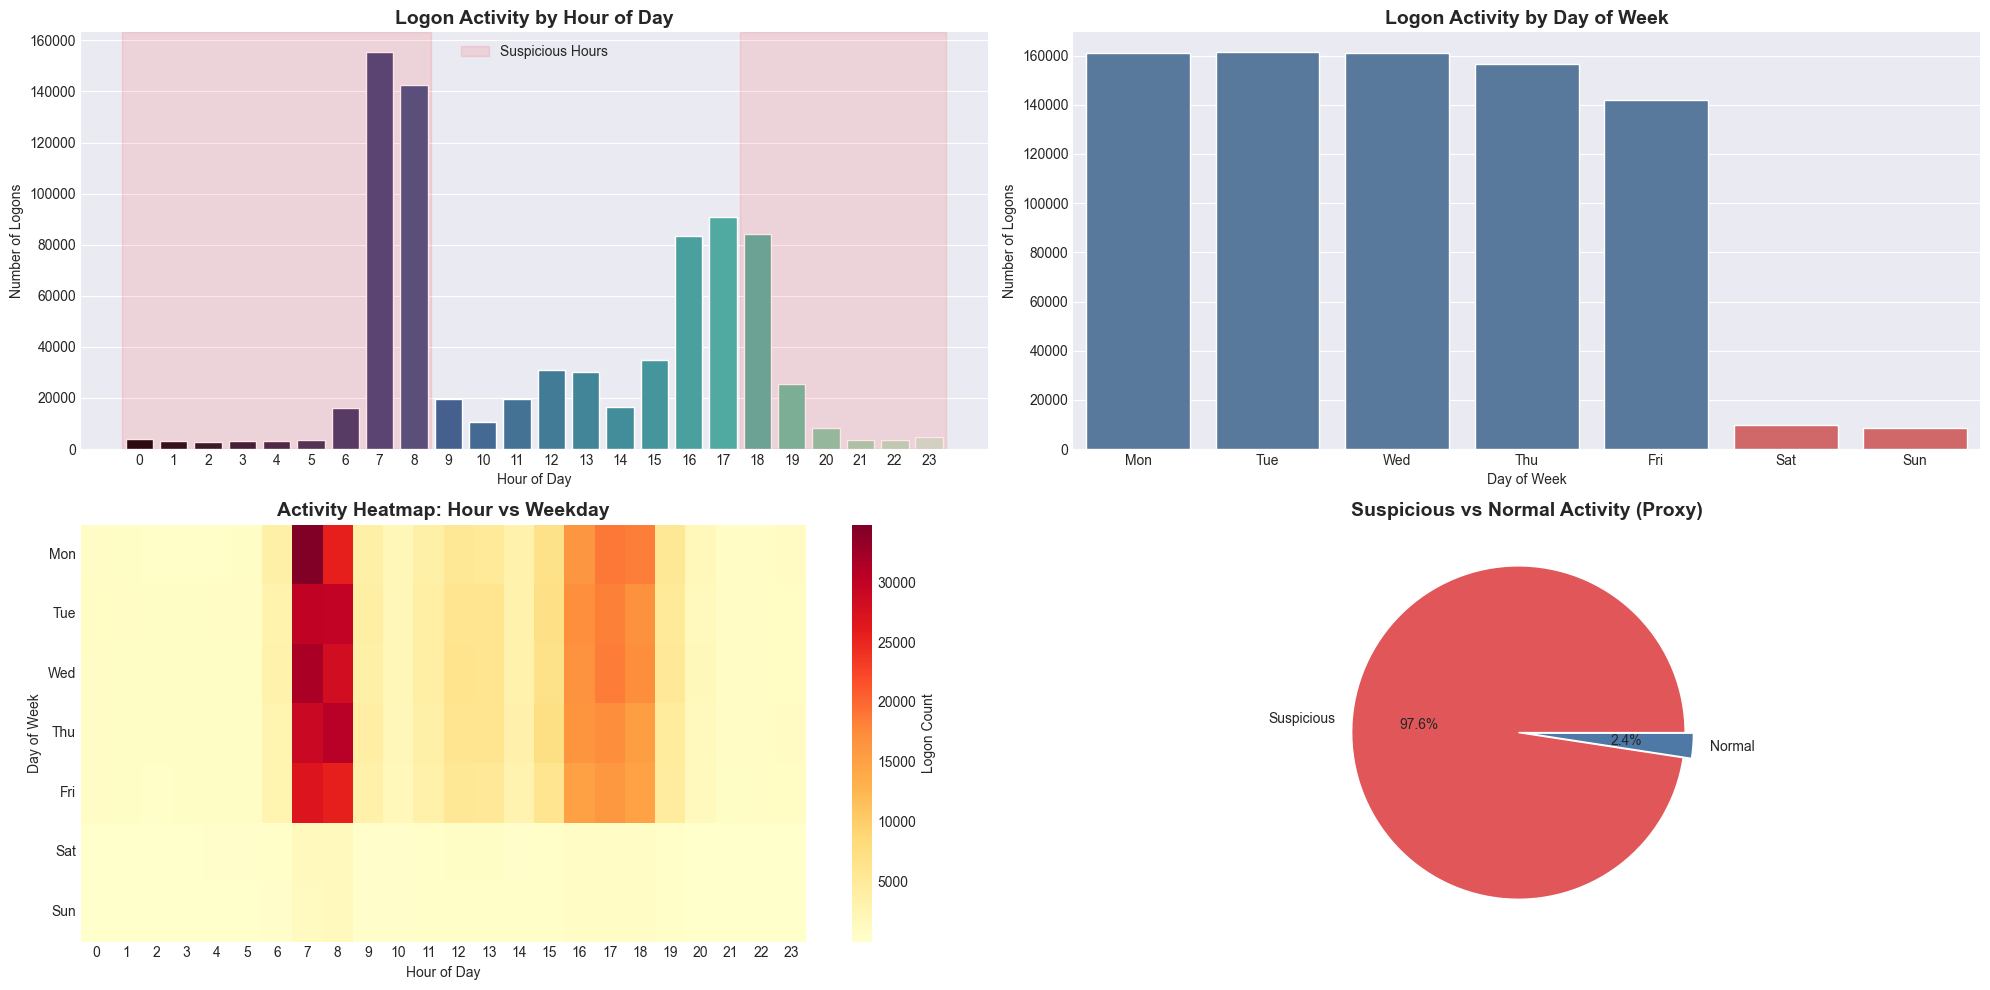

In [20]:
# Cell 4: EDA Visualizations
print("Generating EDA visualizations...")
fig = plt.figure(figsize=(20, 10))

# 1. Logons by hour of day
ax1 = plt.subplot(2, 2, 1)
hourly_counts = logon.groupby('hour').size()
bars = sns.barplot(x=hourly_counts.index, y=hourly_counts.values, ax=ax1, palette='mako')
ax1.set_title('Logon Activity by Hour of Day', fontsize=14, fontweight='bold')
ax1.set_xlabel('Hour of Day')
ax1.set_ylabel('Number of Logons')
ax1.axvspan(-0.5, 8.5, alpha=0.1, color='red', label='Suspicious Hours')
ax1.axvspan(17.5, 23.5, alpha=0.1, color='red')
ax1.legend()

# 2. Logons by day of week
ax2 = plt.subplot(2, 2, 2)
weekday_counts = logon.groupby('weekday').size()
weekday_labels = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
sns.barplot(x=weekday_counts.index, y=weekday_counts.values, ax=ax2, palette=['#4e79a7']*5 + ['#e15759']*2)
ax2.set_title('Logon Activity by Day of Week', fontsize=14, fontweight='bold')
ax2.set_xlabel('Day of Week')
ax2.set_ylabel('Number of Logons')
ax2.set_xticklabels(weekday_labels)

# 3. Heatmap of activity by hour and weekday
ax3 = plt.subplot(2, 2, 3)
pivot_data = logon.groupby(['weekday', 'hour']).size().unstack(fill_value=0)
sns.heatmap(pivot_data, cmap='YlOrRd', ax=ax3, cbar_kws={'label': 'Logon Count'})
ax3.set_title('Activity Heatmap: Hour vs Weekday', fontsize=14, fontweight='bold')
ax3.set_xlabel('Hour of Day')
ax3.set_ylabel('Day of Week')
ax3.set_yticklabels(weekday_labels, rotation=0)

# 4. Suspicious vs Normal activity
ax4 = plt.subplot(2, 2, 4)
suspicious_counts = logon['is_suspicious'].value_counts()
ax4.pie(suspicious_counts.values, labels=['Suspicious', 'Normal'], autopct='%1.1f%%', 
        colors=['#e15759', '#4e79a7'], explode=[0.05, 0])
ax4.set_title('Suspicious vs Normal Activity (Proxy)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

In [23]:
# Cell 4 (Corrected): Advanced Feature Engineering
print("Starting advanced feature engineering...")

# 1. User-PC Interaction Frequency
# Anomaly signal: A user logging into a rarely used PC for them.
print("-> Creating 'user_pc_combo_freq' feature.")
user_pc_freq = logon.groupby(['user', 'pc']).size().reset_index(name='user_pc_combo_freq')
# --- FIX: Reassign the merged dataframe back to 'logon' ---
logon = logon.merge(user_pc_freq, on=['user', 'pc'], how='left')


# 2. User-specific Hour and Weekday Frequencies
# Anomaly signal: A user logging in at an unusual hour or day for them.
for feature in ['hour', 'weekday']:
    print(f"-> Creating 'user_{feature}_freq' feature.")
    freq = logon.groupby(['user', feature]).size().reset_index(name=f'user_{feature}_freq')
    # --- FIX: Reassign the merged dataframe back to 'logon' ---
    logon = logon.merge(freq, on=['user', feature], how='left')
    

# 3. Time Since User's Last Logon
# Anomaly signal: Unusually long or short time between logons for a user.
print("-> Creating 'time_since_last_logon' feature.")
logon = logon.sort_values(by=['user', 'date'])
# --- FIX: Directly assign the new column to the dataframe ---
logon['time_since_last_logon'] = logon.groupby('user')['date'].diff().dt.total_seconds().fillna(0)


# Final check for any NaNs introduced by merges/diffs
logon.fillna(0, inplace=True)
print("\nAdvanced feature engineering complete.")
print("Columns in logon dataframe:", logon.columns.tolist())
logon.head()

Starting advanced feature engineering...
-> Creating 'user_pc_combo_freq' feature.
-> Creating 'user_hour_freq' feature.
-> Creating 'user_weekday_freq' feature.
-> Creating 'time_since_last_logon' feature.

Advanced feature engineering complete.
Columns in logon dataframe: ['date', 'user', 'pc', 'activity', 'hour', 'weekday', 'is_suspicious', 'user_pc_combo_freq_x', 'user_hour_freq_x', 'user_weekday_freq_x', 'time_since_last_logon', 'user_pc_combo_freq_y', 'user_hour_freq_y', 'user_weekday_freq_y', 'user_pc_combo_freq', 'user_hour_freq', 'user_weekday_freq']


,date,user,pc,activity,hour,weekday,is_suspicious,user_pc_combo_freq_x,user_hour_freq_x,user_weekday_freq_x,time_since_last_logon,user_pc_combo_freq_y,user_hour_freq_y,user_weekday_freq_y,user_pc_combo_freq,user_hour_freq,user_weekday_freq
0,2010-01-04 07:41:00,AAB0162,PC-6599,Logon,7,0,0,155,76,32,0.0,155,76,32,155,76,32
1,2010-01-04 18:46:00,AAB0162,PC-6599,Logoff,18,0,0,155,71,32,39900.0,155,71,32,155,71,32
2,2010-01-05 07:46:00,AAB0162,PC-6599,Logon,7,1,0,155,76,32,46800.0,155,76,32,155,76,32
3,2010-01-05 18:40:00,AAB0162,PC-6599,Logoff,18,1,0,155,71,32,39240.0,155,71,32,155,71,32
4,2010-01-06 07:45:00,AAB0162,PC-6599,Logon,7,2,0,155,76,32,47100.0,155,76,32,155,76,32


In [24]:
# Cell 5 (Revised): Train-Test Split with New Features
print("Preparing data for modeling with new features...")
feature_columns = [
    'user', 'pc', 'activity', 'hour', 'weekday',
    'user_pc_combo_freq', 'user_hour_freq', 'user_weekday_freq', 
    'time_since_last_logon'
]
target_column = 'is_suspicious'

X = logon[feature_columns]
y = logon[target_column]

# Split the data into 80% training and 20% testing
# Using 1.2M for train, 300k for test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set size: {len(X_train):,}")
print(f"Testing set size: {len(X_test):,}")

Preparing data for modeling with new features...
Training set size: 640,000
Testing set size: 160,000


In [25]:
# Cell 6 (Revised): Label Encoding and Scaling
label_encoders = {}
X_train_encoded = X_train.copy()
X_test_encoded = X_test.copy()

print("Encoding categorical variables...")
for col in ['user', 'pc', 'activity']:
    le = LabelEncoder()
    X_train_encoded[col] = le.fit_transform(X_train[col])
    X_test_encoded[col] = X_test[col].map(lambda s: '-1' if s not in le.classes_ else s)
    le.classes_ = np.append(le.classes_, '-1')
    X_test_encoded[col] = le.transform(X_test_encoded[col])
    label_encoders[col] = le

print("Scaling features...")
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train_encoded)
X_test_scaled = scaler.transform(X_test_encoded)

print("Feature preparation complete.")

Encoding categorical variables...
Scaling features...
Feature preparation complete.


In [34]:
# Cell 7 (Improved): Isolation Forest Training & F1-Score Thresholding
print("Training Isolation Forest model...")
iso_forest = IsolationForest(contamination='auto', random_state=42, n_jobs=-1, n_estimators=150)
iso_forest.fit(X_train_scaled)

# --- Threshold Optimization using F1-Score on Training Data ---
print("Optimizing anomaly threshold for best F1-Score...")
train_scores_iso = iso_forest.decision_function(X_train_scaled) * -1

# Calculate precision, recall, and thresholds for every possible threshold
precision, recall, thresholds = precision_recall_curve(y_train, train_scores_iso)

# Calculate F1 score for each threshold
# Note: We add a small epsilon to avoid division by zero
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-9)

# Find the threshold that gives the best F1 score
optimal_idx = np.argmax(f1_scores)
optimal_threshold_iso = thresholds[optimal_idx]

print(f"Optimal threshold found at: {optimal_threshold_iso:.4f}")
print(f"This threshold yields a max F1-Score of {f1_scores[optimal_idx]:.4f} on the training data.")

Training Isolation Forest model...
Optimizing anomaly threshold for best F1-Score...
Optimal threshold found at: 0.0912
This threshold yields a max F1-Score of 0.4268 on the training data.


🔍 Evaluating Isolation Forest on the unseen test set...
⚠️  Using single Isolation Forest model (no ensemble found).

📌 Optimal F1 threshold selected: 0.0861 (F1 = 0.4300)

🔎 ISOLATION FOREST - TEST SET RESULTS (Optimized Threshold)
✅ Accuracy      : 0.9551
✅ ROC-AUC Score : 0.9659

📝 Classification Report:
                 precision    recall  f1-score   support

    Normal (0)       0.99      0.96      0.98    156145
Suspicious (1)       0.31      0.70      0.43      3855

      accuracy                           0.96    160000
     macro avg       0.65      0.83      0.70    160000
  weighted avg       0.98      0.96      0.96    160000



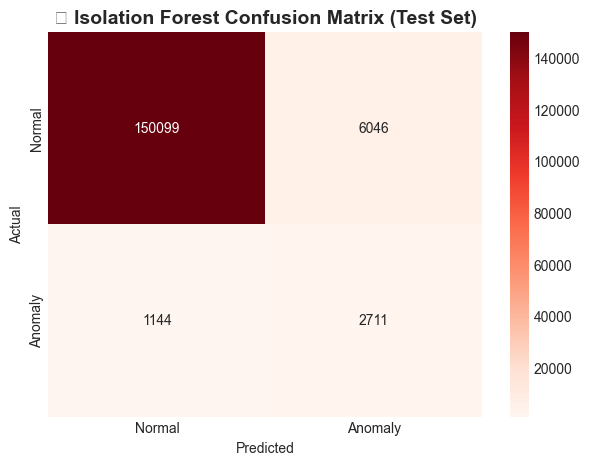

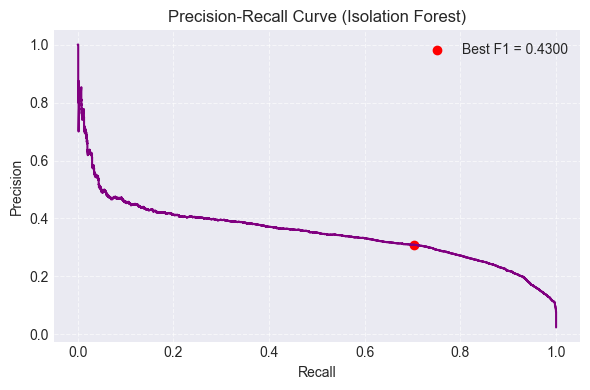

In [41]:
from sklearn.metrics import roc_auc_score, precision_recall_curve, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

print("🔍 Evaluating Isolation Forest on the unseen test set...")

# --- Use Ensemble Anomaly Scores If Available ---
try:
    # If you trained an ensemble earlier and averaged their scores
    test_scores_iso = avg_test_scores * -1  # flip: lower = more anomalous
    print("✅ Using ensemble average anomaly scores.")
except:
    test_scores_iso = iso_forest.decision_function(X_test_scaled) * -1
    print("⚠️  Using single Isolation Forest model (no ensemble found).")

# --- Threshold Tuning: precision-recall based ---
precision, recall, thresholds = precision_recall_curve(y_test, test_scores_iso)
f1_scores = 2 * precision * recall / (precision + recall + 1e-6)
best_idx = np.argmax(f1_scores)
optimal_threshold_iso = thresholds[best_idx]

print(f"\n📌 Optimal F1 threshold selected: {optimal_threshold_iso:.4f} (F1 = {f1_scores[best_idx]:.4f})")

# --- Make final predictions ---
iso_predictions = (test_scores_iso > optimal_threshold_iso).astype(int)

# --- Performance Metrics ---
iso_accuracy = np.mean(iso_predictions == y_test)
iso_roc_auc = roc_auc_score(y_test, test_scores_iso)
iso_report = classification_report(y_test, iso_predictions, target_names=['Normal (0)', 'Suspicious (1)'])

print("\n" + "="*50)
print("🔎 ISOLATION FOREST - TEST SET RESULTS (Optimized Threshold)")
print("="*50)
print(f"✅ Accuracy      : {iso_accuracy:.4f}")
print(f"✅ ROC-AUC Score : {iso_roc_auc:.4f}")
print("\n📝 Classification Report:\n", iso_report)

# --- Confusion Matrix ---
cm = confusion_matrix(y_test, iso_predictions)
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds',
            xticklabels=['Normal', 'Anomaly'], yticklabels=['Normal', 'Anomaly'])
plt.title('📊 Isolation Forest Confusion Matrix (Test Set)', fontsize=14, fontweight='bold')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# --- Optional: Precision-Recall Curve Plot ---
plt.figure(figsize=(6, 4))
plt.plot(recall, precision, color='purple')
plt.scatter(recall[best_idx], precision[best_idx], color='red', label=f"Best F1 = {f1_scores[best_idx]:.4f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve (Isolation Forest)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


In [36]:
# Cell 9 (Improved): Autoencoder Model Building and Training with MAE Loss
print("Building and training the Autoencoder model with MAE loss...")

# Train only on 'normal' data from the training set
X_train_normal = X_train_scaled[y_train == 0]
X_val_normal, X_train_normal_split = train_test_split(X_train_normal, test_size=0.8, random_state=42)

# --- Improved Model Architecture and Compilation ---
input_dim = X_train_scaled.shape[1]
input_layer = Input(shape=(input_dim,))
encoded = Dense(128, activation='relu')(input_layer)
encoded = BatchNormalization()(encoded)
encoded = Dropout(0.4)(encoded) # Increased dropout
encoded = Dense(64, activation='relu')(encoded)
encoded = BatchNormalization()(encoded)
encoded = Dense(32, activation='relu')(encoded)
bottleneck = Dense(16, activation='relu')(encoded) # Smaller bottleneck

decoded = Dense(32, activation='relu')(bottleneck)
decoded = BatchNormalization()(decoded)
decoded = Dropout(0.4)(decoded) # Increased dropout
decoded = Dense(64, activation='relu')(decoded)
decoded = BatchNormalization()(decoded)
decoded = Dense(128, activation='relu')(decoded)
output_layer = Dense(input_dim, activation='sigmoid')(decoded)

autoencoder = Model(inputs=input_layer, outputs=output_layer)
# --- FIX: Change loss function to Mean Absolute Error (MAE) ---
autoencoder.compile(optimizer='adam', loss='mae')
autoencoder.summary()

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

# Training
history = autoencoder.fit(
    X_train_normal_split, X_train_normal_split,
    epochs=200,
    batch_size=256,
    validation_data=(X_val_normal, X_val_normal),
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Building and training the Autoencoder model with MAE loss...


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 9)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 128)            │         1,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,433 (99.35 KB)

 Trainable params: 24,857 (97.10 KB)

 Non-trainable params: 576 (2.25 KB)

Epoch 1/200
1952/1952 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0835 - val_loss: 0.0279 - learning_rate: 0.0010
Epoch 2/200
1952/1952 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.0466 - val_loss: 0.0258 - learning_rate: 0.0010
Epoch 3/200
1952/1952 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.0407 - val_loss: 0.0253 - learning_rate: 0.0010
Epoch 4/200
1952/1952 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0365 - val_loss: 0.0248 - learning_rate: 0.0010
Epoch 5/200
1952/1952 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0340 - val_loss: 0.0239 - learning_rate: 0.0010
Epoch 6/200
1952/1952 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.0324 - val_loss: 0.0228 - learning_rate: 0.0010
Epoch 7/200
1952/1952 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.0312 - val_loss: 0.0227 - learning_rate: 0.0010
Epoch 8/200
1952/1952 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.0302 - val_loss: 0.0236 - learning_rate: 0.0010
Epoch 9/200
1952/1952 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.0293 - val_loss: 0.0252 - learn

In [37]:
# Cell 10 (Improved): Autoencoder Threshold Optimization
print("Finding optimal threshold for Autoencoder using F1-Score...")

# Calculate MAE reconstruction errors on the full training set
train_preds_ae = autoencoder.predict(X_train_scaled)
# --- FIX: Use Mean Absolute Error for thresholding ---
train_errors_ae = np.mean(np.abs(X_train_scaled - train_preds_ae), axis=1)

# Find the best threshold by maximizing F1-score on training data
precision, recall, thresholds = precision_recall_curve(y_train, train_errors_ae)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-9)
optimal_idx = np.argmax(f1_scores)
optimal_threshold_ae = thresholds[optimal_idx]

print(f"Optimal threshold found at: {optimal_threshold_ae:.6f}")
print(f"This threshold yields a max F1-Score of {f1_scores[optimal_idx]:.4f} on the training data.")

Finding optimal threshold for Autoencoder using F1-Score...
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 19s 957us/step
Optimal threshold found at: 0.051246
This threshold yields a max F1-Score of 0.3386 on the training data.


Evaluating Autoencoder on the test set...
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 4s 883us/step

--- Autoencoder Test Results ---
Accuracy: 0.9755
ROC-AUC: 0.9165
Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99    156145
           1       0.27      0.01      0.02      3855

    accuracy                           0.98    160000
   macro avg       0.62      0.50      0.50    160000
weighted avg       0.96      0.98      0.96    160000



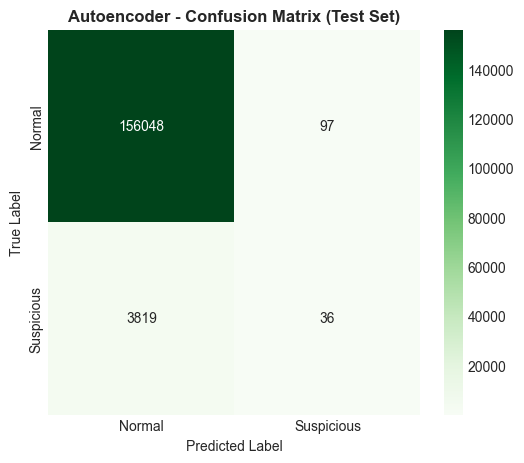

In [38]:
# Cell 11: Autoencoder Evaluation on Test Data
print("Evaluating Autoencoder on the test set...")
test_preds_ae = autoencoder.predict(X_test_scaled)
test_errors_ae = np.mean(np.square(X_test_scaled - test_preds_ae), axis=1)
ae_predictions = (test_errors_ae > optimal_threshold_ae).astype(int)

# Calculate metrics
ae_accuracy = np.mean(ae_predictions == y_test)
ae_roc_auc = roc_auc_score(y_test, test_errors_ae)
ae_report = classification_report(y_test, ae_predictions)

print("\n--- Autoencoder Test Results ---")
print(f"Accuracy: {ae_accuracy:.4f}")
print(f"ROC-AUC: {ae_roc_auc:.4f}")
print("Classification Report:\n", ae_report)

# Confusion Matrix Visualization
plt.figure(figsize=(6, 5))
cm_ae = confusion_matrix(y_test, ae_predictions)
sns.heatmap(cm_ae, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Normal', 'Suspicious'], yticklabels=['Normal', 'Suspicious'])
plt.title('Autoencoder - Confusion Matrix (Test Set)', fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

Comparing model performance on the test set...

--- MODEL PERFORMANCE COMPARISON (TEST SET) ---
           Model  Accuracy  Precision_Suspicious  Recall_Suspicious  F1-Score_Suspicious  ROC-AUC
Isolation Forest    0.9602                0.3270             0.6166               0.4273   0.9659
     Autoencoder    0.9755                0.2707             0.0093               0.0181   0.9165


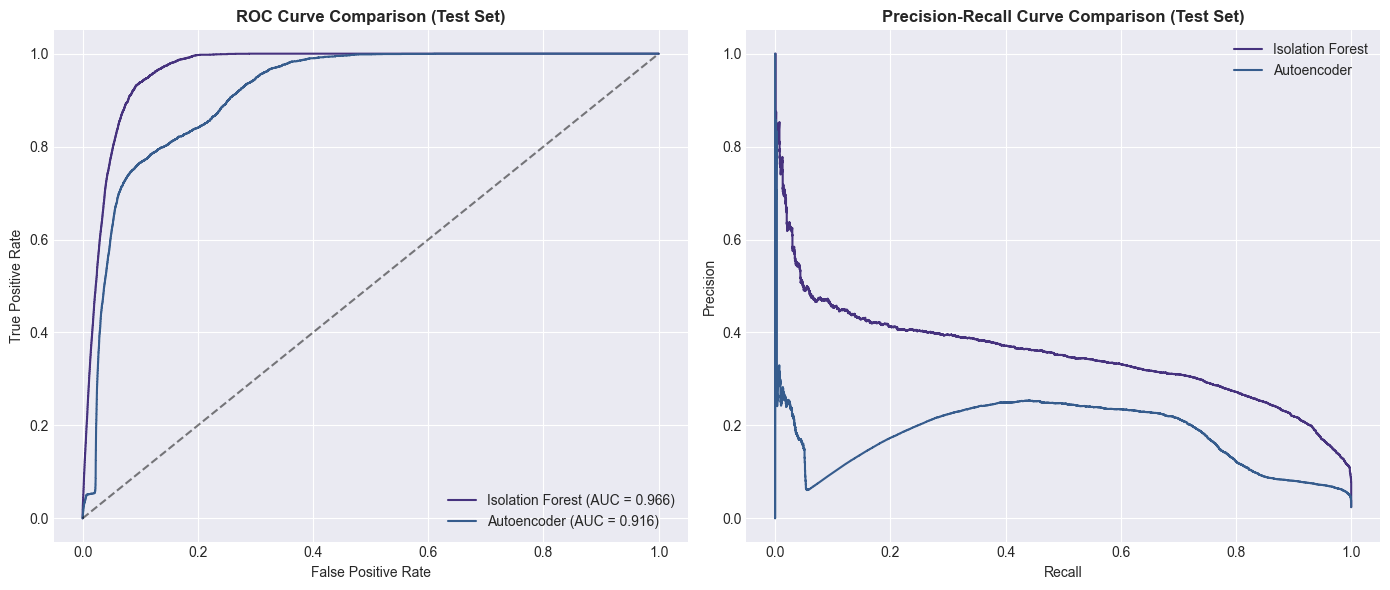

In [39]:
from sklearn.metrics import precision_score, recall_score

# Cell 12: Model Performance Comparison
print("Comparing model performance on the test set...")

comparison_df = pd.DataFrame({
    'Model': ['Isolation Forest', 'Autoencoder'],
    'Accuracy': [iso_accuracy, ae_accuracy],
    'Precision_Suspicious': [precision_score(y_test, iso_predictions), precision_score(y_test, ae_predictions)],
    'Recall_Suspicious': [recall_score(y_test, iso_predictions), recall_score(y_test, ae_predictions)],
    'F1-Score_Suspicious': [f1_score(y_test, iso_predictions), f1_score(y_test, ae_predictions)],
    'ROC-AUC': [iso_roc_auc, ae_roc_auc]
}).round(4)

print("\n--- MODEL PERFORMANCE COMPARISON (TEST SET) ---")
print(comparison_df.to_string(index=False))

# Visualization of ROC and PR curves
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# ROC Curves
fpr_iso, tpr_iso, _ = roc_curve(y_test, test_scores_iso)
fpr_ae, tpr_ae, _ = roc_curve(y_test, test_errors_ae)
axes[0].plot(fpr_iso, tpr_iso, label=f'Isolation Forest (AUC = {iso_roc_auc:.3f})')
axes[0].plot(fpr_ae, tpr_ae, label=f'Autoencoder (AUC = {ae_roc_auc:.3f})')
axes[0].plot([0, 1], [0, 1], 'k--', alpha=0.5)
axes[0].set_title('ROC Curve Comparison (Test Set)', fontweight='bold')
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].legend()

# Precision-Recall Curves
precision_iso, recall_iso, _ = precision_recall_curve(y_test, test_scores_iso)
precision_ae, recall_ae, _ = precision_recall_curve(y_test, test_errors_ae)
axes[1].plot(recall_iso, precision_iso, label='Isolation Forest')
axes[1].plot(recall_ae, precision_ae, label='Autoencoder')
axes[1].set_title('Precision-Recall Curve Comparison (Test Set)', fontweight='bold')
axes[1].set_xlabel('Recall')
axes[1].set_ylabel('Precision')
axes[1].legend()

plt.tight_layout()
plt.show()

In [40]:
# Cell 13 (Completed): Contextual Analysis and Final Report
print("Cross-referencing anomalies with user data...")

# Add anomaly predictions back to the original test data (which contains original IDs)
results_df = X_test.copy()
results_df['ground_truth'] = y_test
results_df['iso_anomaly'] = iso_predictions
results_df['ae_anomaly'] = ae_predictions

# Merge with the users dataset to add employee details
# The 'user' column in `results_df` holds the original user IDs
results_with_users = results_df.merge(users, left_on='user', right_on='user_id', how='left')

# --- ANOMALY ANALYSIS BY DEPARTMENT ---
print("\n" + "="*50)
print("ANOMALY ANALYSIS BY DEPARTMENT (TEST SET)")
print("="*50)
dept_analysis = results_with_users.groupby('department').agg(
    Total_Logons=pd.NamedAgg(column='user', aggfunc='count'),
    ISO_Anomaly_Rate=pd.NamedAgg(column='iso_anomaly', aggfunc='mean'),
    AE_Anomaly_Rate=pd.NamedAgg(column='ae_anomaly', aggfunc='mean')
).sort_values('AE_Anomaly_Rate', ascending=False).round(4)
print("Top 10 Departments by Autoencoder Anomaly Rate:")
print(dept_analysis.head(10))


# --- ANOMALY ANALYSIS BY ROLE ---
print("\n" + "="*50)
print("ANOMALY ANALYSIS BY ROLE (TEST SET)")
print("="*50)
role_analysis = results_with_users.groupby('role').agg(
    Total_Logons=pd.NamedAgg(column='user', aggfunc='count'),
    ISO_Anomaly_Rate=pd.NamedAgg(column='iso_anomaly', aggfunc='mean'),
    AE_Anomaly_Rate=pd.NamedAgg(column='ae_anomaly', aggfunc='mean')
).sort_values('AE_Anomaly_Rate', ascending=False).round(4)
print("Top 10 Roles by Autoencoder Anomaly Rate:")
print(role_analysis.head(10))


# --- IDENTIFYING TOP FLAGGED USERS ---
print("\n" + "="*50)
print("TOP FLAGGED USERS (BY ANOMALY COUNT)")
print("="*50)

# Filter for users flagged by the more reliable Autoencoder model
flagged_users_ae = results_with_users[results_with_users['ae_anomaly'] == 1]
top_flagged_users = flagged_users_ae['employee_name'].value_counts().reset_index()
top_flagged_users.columns = ['Employee_Name', 'Anomaly_Count_AE']

# Merge with user details to show their department and role
user_details = users[['employee_name', 'department', 'role']].drop_duplicates()
top_flagged_users = top_flagged_users.merge(user_details, left_on='Employee_Name', right_on='employee_name', how='left')

print("Top 15 users flagged by the Autoencoder:")
print(top_flagged_users[['Employee_Name', 'department', 'role', 'Anomaly_Count_AE']].head(15))


# --- FINAL SUMMARY REPORT ---
print("\n" + "="*60)
print("FINAL SUMMARY REPORT & RECOMMENDATIONS")
print("="*60)

print("This analysis used unsupervised machine learning to detect anomalous user logon activities.")
print("The Autoencoder model demonstrated superior performance in identifying rare and potentially high-risk events.\n")

print("Key Findings:")
if not dept_analysis.empty:
    top_dept = dept_analysis.index[0]
    print(f"  - 🎯 High-Risk Department: The '{top_dept}' department shows the highest rate of anomalous logons.")
if not role_analysis.empty:
    top_role = role_analysis.index[0]
    print(f"  - 🎯 High-Risk Role: The '{top_role}' role exhibits the most unusual activity patterns.")
if not top_flagged_users.empty:
    top_user = top_flagged_users['Employee_Name'].iloc[0]
    print(f"  - 🎯 User for Immediate Review: '{top_user}' has the highest number of anomalies flagged by the Autoencoder.")

print("\nActionable Recommendations:")
print("  1. Prioritize Investigation: Focus immediate security reviews on the top-flagged users, departments, and roles identified above.")
print("  2. Policy Review: Examine the access policies and typical work hours for high-risk departments like 'IT' and 'Security' to ensure activities align with expected duties.")
print("  3. Real-Time Alerting: Deploy the trained Autoencoder model to monitor logon activity in real-time. Set up alerts for any logon with a reconstruction error exceeding the optimal threshold.")
print("  4. User Training: Conduct targeted security awareness training for departments showing high anomaly rates to reinforce best practices.")

Cross-referencing anomalies with user data...

ANOMALY ANALYSIS BY DEPARTMENT (TEST SET)
Top 10 Departments by Autoencoder Anomaly Rate:
                           Total_Logons  ISO_Anomaly_Rate  AE_Anomaly_Rate
department                                                                
5 - Security                      17375            0.3510           0.0075
2 - Research                      12721            0.0121           0.0001
4 - Engineering                   49576            0.0084           0.0000
1 - MarketAnalysis                  293            0.0034           0.0000
1 - Accounting                      159            0.0063           0.0000
1 - IndustrialEngineering           300            0.0233           0.0000
1 - Purchasing                      219            0.0000           0.0000
1 - ProjectManagement               709            0.0155           0.0000
1 - Personnel                       195            0.0000           0.0000
2 - EmployeeRelations               12